In [7]:
from utils import *
from Visualization import *

from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import random_split
from typing import *
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113


In [308]:
history = {}
input_size = (224,224)
data_dir = "./data/MIT_split"

key_execution = "scale_"+str(input_size)+"_unfroze3"
history[key_execution] = {"losses": None, "acc": None }

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

batch_size = 8


In [309]:
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}


In [310]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 1892
     Root location: ./data/MIT_split/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 807
     Root location: ./data/MIT_split/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [311]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    acc_history = {"train": [], "test": []}
    losses = {"train": [], "test": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            acc_history[phase].append(epoch_acc.item())
            losses[phase].append(epoch_loss)


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, acc_history, losses



def save_model(model_state_dict: object, path, filename:str) -> None:
    if not os.path.isdir(path):
        os.makedirs(path)
    torch.save(model_state_dict(), os.path.join(path, filename))


def write_pickle(information:Any,filepath:str):
    """
    Serialize and write an object to the specified file using pickle.

    Parameters:
        information (Any): The object to be serialized and written.
        filepath (str): The path to the file to write the pickled object.
    """

    abs_path = os.path.dirname(filepath)
    os.makedirs(abs_path, exist_ok=True)
    with open(filepath, "wb") as f:
        pickle.dump(information, f)


def SVM_Loss(output, weight, y_true, num_classes):
    y = F.one_hot(y_true, num_classes = num_classes).to(output.device)
    y[y!=1] = -1
    tmp = torch.zeros_like(y).to(y.device)
    regularizer = torch.mean(weight.T@weight)
    maximum = torch.maximum(tmp, 1 -  y * output )
    loss = torch.mean(maximum)
    
    return regularizer + loss * 0.2


In [312]:
class Efficient_net(nn.Module):
    def __init__(self, freeze= True):
        super(Efficient_net, self).__init__()
        
        self._freeze = freeze
        
        self._eff = models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT")
        
        self.features = self._eff.features
        
        self.avgpool = self._eff.avgpool
        
        self.classifier = self._eff.classifier
        
        self.gradients = None
        
        self.set_parameter_requires_grad(freeze)
        
        
    def set_parameter_requires_grad(self, feature_extracting):
        if feature_extracting:
            for param in self.parameters():
                param.requires_grad = False


    def activate_gradients(self):
        for param in self.parameters():
            param.requires_grad = True


    def activate_marginal_gradients(self, indexing, flow:str = "bottom"):
        if flow == "bottom": params = self.features[:indexing+1].parameters() 
        else:params = self.features[indexing:].parameters()
            
        for param in params:
            param.requires_grad = True
        
    def forward(self, x):
        
        x = self.features(x)
        if not self._freeze:
            h = x.register_hook(self.activations_hook)
            self.gradients = h
            
        view = x.shape[:2]
        
        x = self.avgpool(x).view(view)
        x = self.classifier(x)
        
        
        return x
    
    def set_linear(self, output_size):
        self.classifier[-1] = nn.Linear(1280, output_size)
        
    def activations_hook(self, grad):
        print(grad)
        print("golaaa")
        self.gradients = grad
        
    def get_activations_gradient(self):
        return self.gradients
        
        

In [313]:
num_classes = 8

In [314]:
model = Efficient_net()
model.set_linear(num_classes)
model.activate_marginal_gradients(-3, flow="top")

In [315]:
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

print(len(params_to_update))
# Observe that all parameters are being optimized

70


In [316]:
#model, _ = initialize_model(8)

In [317]:
# Send the model to GPU
model = model.to(device)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Number of epochs to train for 
num_epochs = 15

optimizer_ft = optim.Adam(model.parameters(), lr=0.001)

# Train and evaluate
#model, hist, losses = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

In [318]:
# ### plot the losses and accuracies
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# ax1.plot(losses["train"], label="training loss")
# ax1.plot(losses["test"], label="validation loss")
# ax1.legend()

# ax2.plot(hist["train"],label="training accuracy")
# ax2.plot(hist["test"],label="val accuracy")
# ax2.legend()

# plt.show()  

In [319]:
# history[key_execution]["losses"] = losses
# history[key_execution]["acc"] = hist
# save_model(model.state_dict, filename=key_execution+".pt", path="./checkpoints/eff")

In [320]:
# write_pickle(filepath="./results_per_patch_unfreeze.pkl", information=history) 

## Loading Model and Results

In [321]:
model.load_state_dict(torch.load("./checkpoints/eff/"+key_execution+".pt"))

<All keys matched successfully>

In [322]:
def get_pickle(path):
    with open(path, "rb") as handle:
        gr=pickle.load(handle)
    return gr

history = get_pickle("./results_per_patch_unfreeze.pkl")

In [323]:
print(history.keys())

dict_keys(['scale_(224, 224)', 'scale_(256, 256)', 'scale_(64, 64)', 'scale_(64, 64)_unfroze2', 'scale_(96, 96)_unfroze2', 'scale_(128, 128)_unfroze2', 'scale_(224, 224)_unfroze2', 'scale_(256, 256)_unfroze2', 'scale_(96, 96)_unfroze3', 'scale_(64, 64)_unfroze3', 'scale_(224, 224)_unfroze3', 'scale_(256, 256)_unfroze3', 'scale_(64, 64)_unfroze4', 'scale_(96, 96)_unfroze4', 'scale_(128, 128)_unfroze4', 'scale_(224, 224)_unfroze4', 'scale_(256, 256)_unfroze4', 'scale_(96, 96)', 'scale_(128, 128)', 'scale_(128, 128)_unfroze3'])


['scale_(64, 64)', 'scale_(96, 96)', 'scale_(128, 128)', 'scale_(224, 224)', 'scale_(256, 256)']


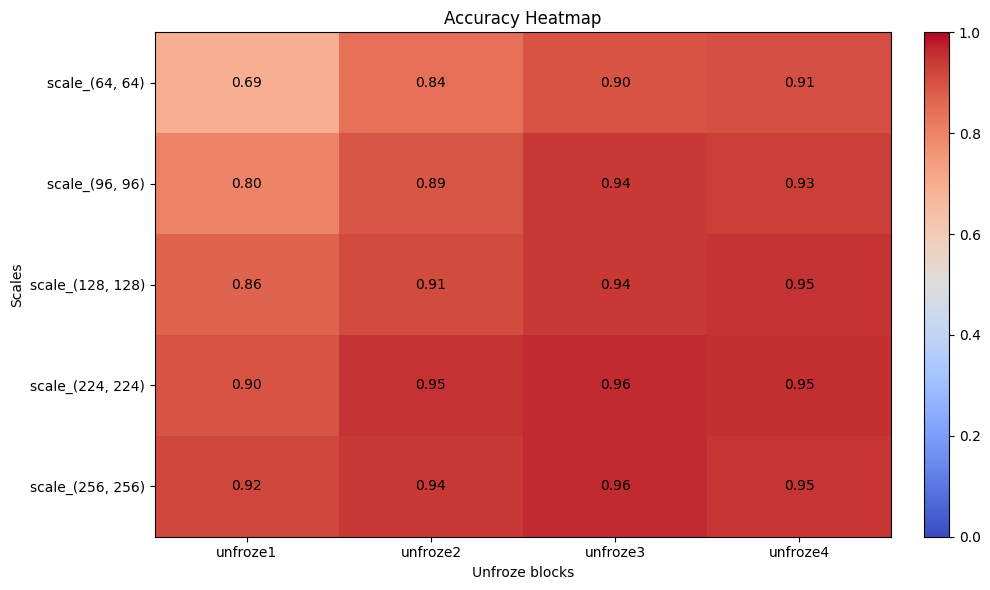

In [324]:
import matplotlib.pyplot as plt
import numpy as np

def obtener_valor_escala(cadena):
    inicio = cadena.find('(') + 1
    fin = cadena.find(')')
    valores = cadena[inicio:fin].split(',')
    return int(valores[0]), int(valores[1])

# Ejemplo de diccionario de datos
data = copy.copy(history)
# Extraer las escalas y los unfroze<int>
scales = set()
unfroze_values = set()

for key in data.keys():
    if len(key.split("_")) < 3:
        scale = key
        unfroze = 1
    else:
        scale, unfroze = key.split('_unfroze')
    scales.add(scale)
    unfroze_values.add(int(unfroze))

# Ordenar las escalas y los unfroze<int>
scales = sorted(list(scales), key=obtener_valor_escala)
print(scales)
unfroze_values = sorted(list(unfroze_values))

# Crear un solo heatmap para el accuracy
heatmap_data_accuracy = np.zeros((len(scales), len(unfroze_values)))

for i, scale in enumerate(scales):
    for j, unfroze in enumerate(unfroze_values):
        if unfroze == 1:
            
            key = f"{scale}"
        else:
            key = f"{scale}_unfroze{unfroze}"
            
        if key in data:
            heatmap_data_accuracy[i, j] = np.max(data[key]['acc']["test"])

# Crear el heatmap
fig, ax = plt.subplots(figsize=(10, 6))

im_accuracy = ax.imshow(heatmap_data_accuracy, cmap='coolwarm', vmin=0, vmax=1, aspect='auto', origin='upper')


# Añadir anotaciones
for i in range(len(scales)):
    for j in range(len(unfroze_values)):
        value = heatmap_data_accuracy[i, j]
        ax.text(j, i, f'{value:.2f}', ha='center', va='center', color='black')


ax.set_title('Accuracy Heatmap')
ax.set_xticks(np.arange(len(unfroze_values)))
ax.set_xticklabels([f'unfroze{unfroze}' for unfroze in unfroze_values])
ax.set_yticks(np.arange(len(scales)))
ax.set_yticklabels(scales)
ax.set_xlabel('Unfroze blocks')
ax.set_ylabel('Scales')
fig.colorbar(im_accuracy, orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()



In [325]:
import pandas as pd
import seaborn as sns

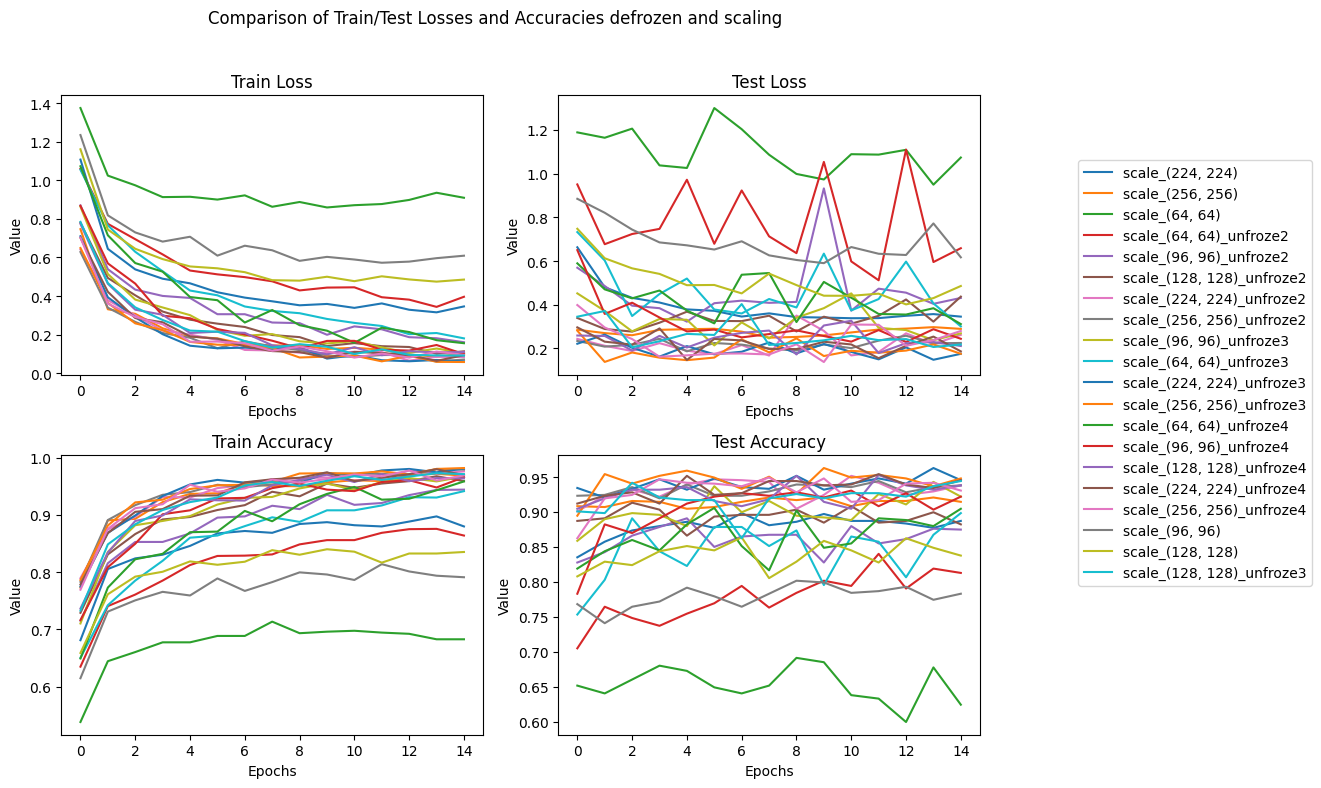

In [326]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Comparison of Train/Test Losses and Accuracies defrozen and scaling')

# Iterate over each key in the dictionary
for i, (key, values) in enumerate(history.items()):
    # Train Loss plot
    axs[0, 0].plot(values['losses']['train'], label=key)
    axs[0, 0].set_title('Train Loss')

    # Test Loss plot
    axs[0, 1].plot(values['losses']['test'], label=key)
    axs[0, 1].set_title('Test Loss')

    # Train Accuracy plot
    axs[1, 0].plot(values['acc']['train'], label=key)
    axs[1, 0].set_title('Train Accuracy')

    # Test Accuracy plot
    axs[1, 1].plot(values['acc']['test'], label=key)
    axs[1, 1].set_title('Test Accuracy')

# Add legends and labels
for ax in axs.flat:
    ax.set(xlabel='Epochs', ylabel='Value')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.2, 0.8))

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plots
plt.show()

## Applying GradCam adn explainability

In [327]:
@torch.no_grad()  # prevent this function from computing gradients 
def get_mistakes(model, loader):
    

    val_loss = 0
    correct = 0

    model.eval()
    final_images = []
    final_targets =  []
    errors_im = []
    predictions = []

    for data, target in loader:
        data, target = data.to(device), target.to(device)
    
        output = model(data)
        p = F.softmax(output, dim=1)
        scr, pred = p.data.max(1, keepdim=True) # get the index of the max log-probability   
        
        predictions += (list(pred.cpu().numpy()))
        correct += pred.eq(target.view_as(pred)).sum().item()
        non_correcte = (pred != target.view_as(pred)).squeeze() 
        image_indexes = data[non_correcte,:,:,:]
        image_targets = target[non_correcte]

        errors = pred[non_correcte]
    
        final_images.append(image_indexes.cpu())
        final_targets.append(image_targets.cpu().numpy())
        errors_im.append(errors.cpu().numpy())

    return final_images, final_targets, errors_im

@torch.no_grad()  # prevent this function from computing gradients 
def validate(criterion, model, loader):
    
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
    
        _, preds = torch.max(outputs, 1)
    

    
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)
        
    print('{} Loss: {:.4f} Acc: {:.4f}'.format("test", epoch_loss, epoch_acc))




In [328]:
validate(model=model.cuda(), criterion=criterion, loader=dataloaders_dict["test"])

test Loss: 0.2306 Acc: 0.9331


In [329]:
#model._freeze = True
misatke_images, gt, predictions = get_mistakes(model=model, loader=dataloaders_dict["test"])

In [330]:
def tensor_to_image(img):
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                         std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                         std = [ 1., 1., 1. ]),
                                   ])
    img = invTrans(img)
    img = img.permute(1, 2, 0) 
    img = (img.numpy()*255).astype(np.uint8)
    return img #Image.fromarray(tensor, "RGB")

convert_tensor = transforms.ToTensor()

inverse_mapping_classes = {j:i for i, j in dataloaders_dict["test"].dataset.class_to_idx.items()}

In [331]:
(misatke_images[3].shape)

torch.Size([0, 3, 224, 224])

In [332]:
predictions = [i for i in predictions if len(i) != 0 ]
images_test = [(i) for i in misatke_images if len(i) != 0 ]
gt_test = [i for i in gt if len(i) != 0]

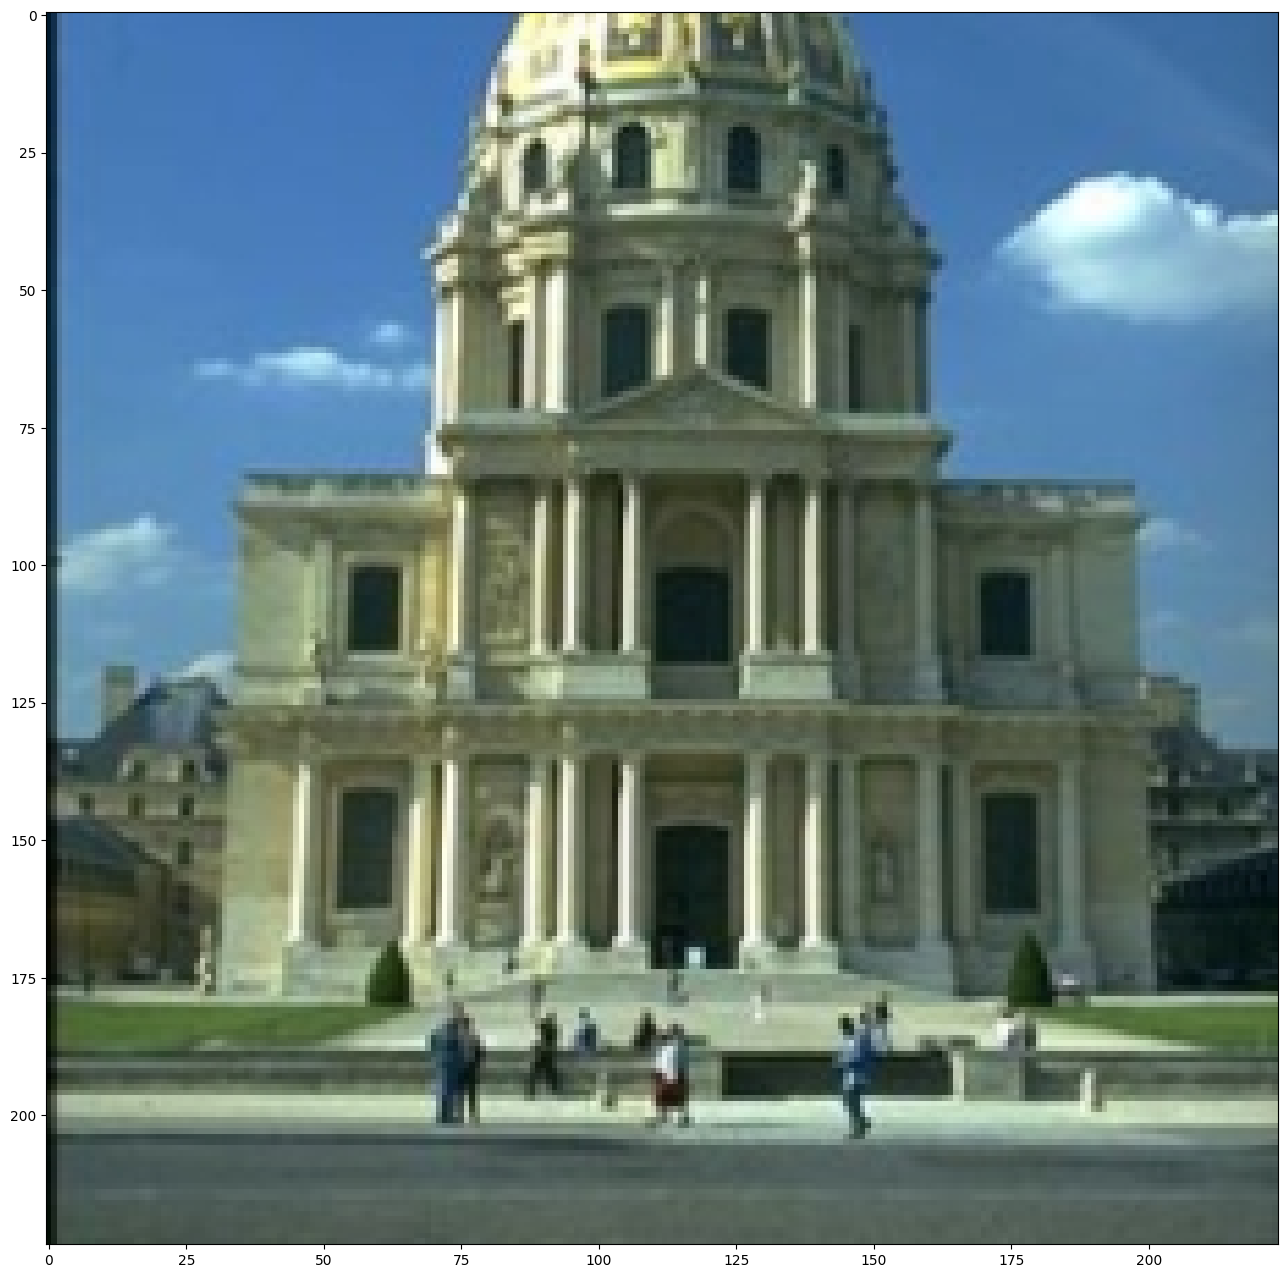

In [333]:
plt.imshow(tensor_to_image(images_test[0][0]))


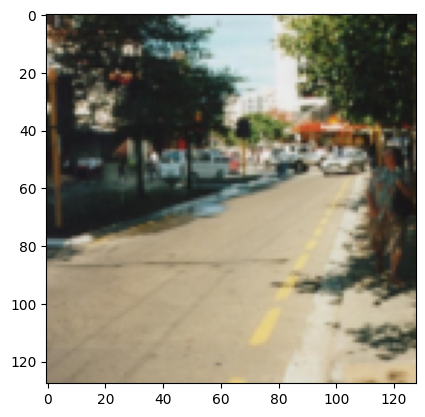

In [59]:
plt.imshow(tensor_to_image(images_test[0][0]))

In [85]:
img_test = tensor_to_image(images_test[0][0])

In [86]:
model_traced = module2traced(model, images_test[0][0].unsqueeze(0).cuda())

In [87]:
from Visualization.core.Weights import *

vis = Weights(model, device)

In [88]:
len(model_traced)

446

In [93]:
first_layer = model_traced[32]

In [94]:
first_layer

Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=False)

In [95]:
plt.rcParams["figure.figsize"]= 16,16

In [96]:
predictions[0]

array([[2]])

In [97]:
inverse_mapping_classes[predictions[0][0][0]], inverse_mapping_classes[gt_test[0][0]]

('forest', 'highway')

torch.Size([1, 32, 32])


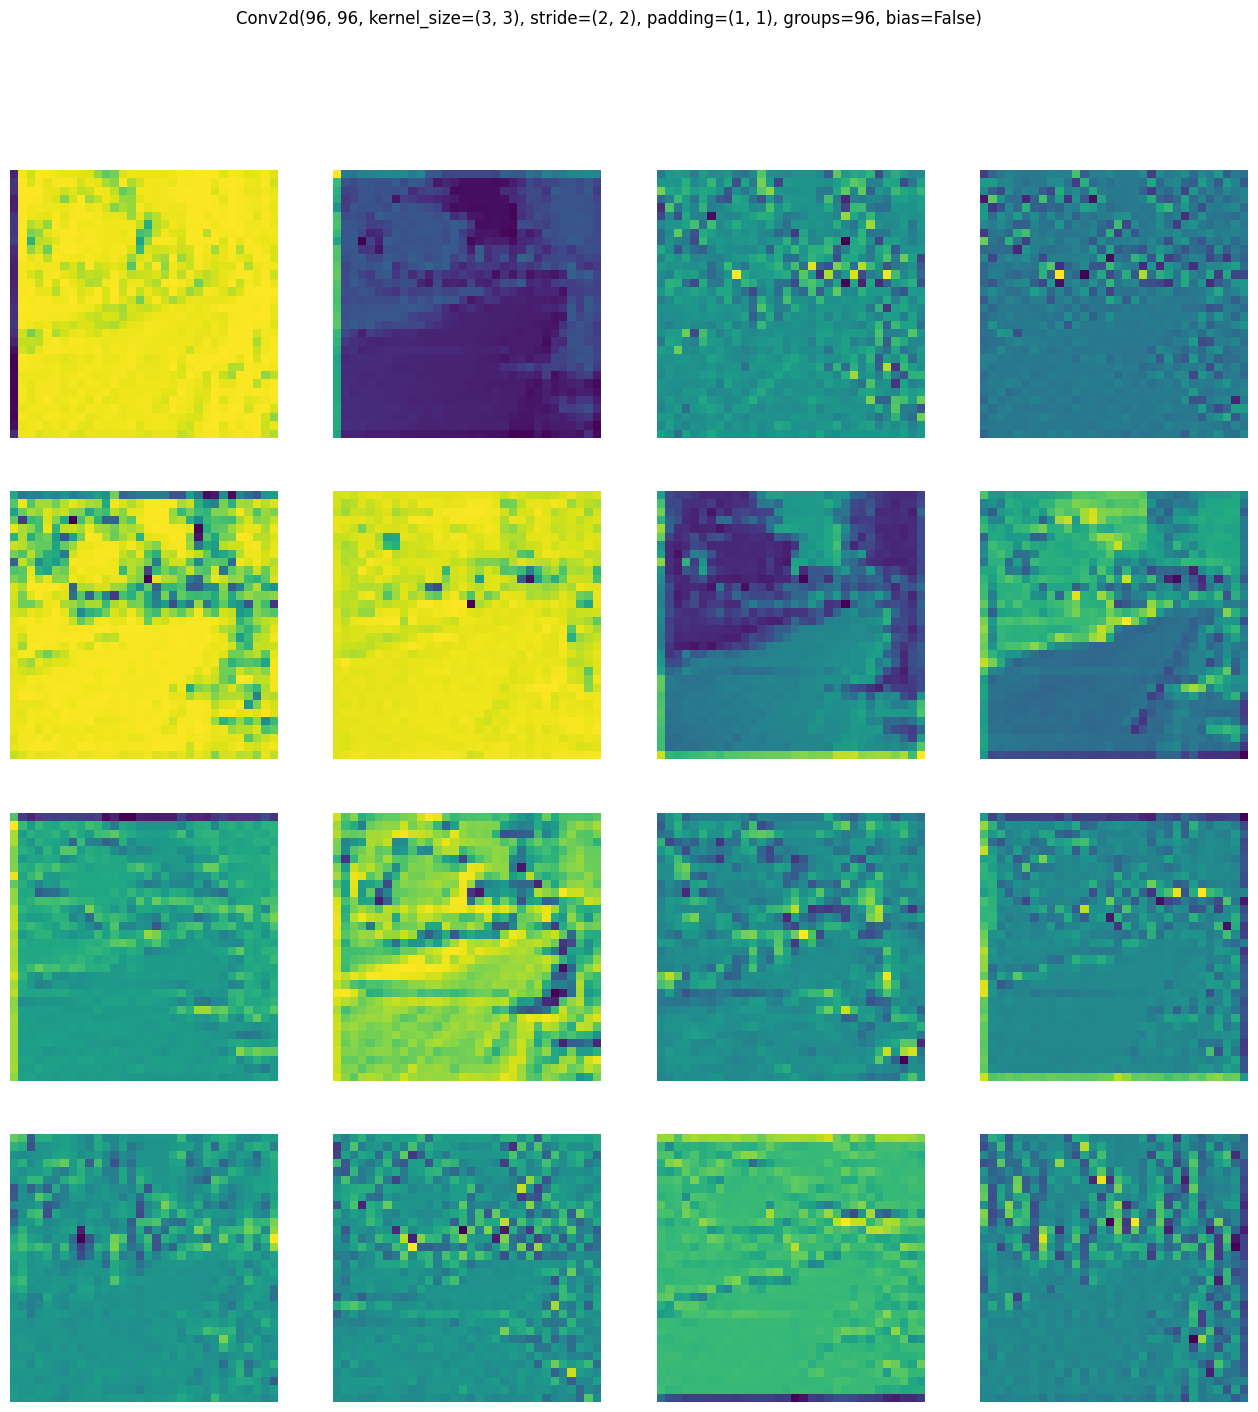

In [98]:
run_vis_plot(vis,convert_tensor(img_test).unsqueeze(0).cuda(), first_layer, ncols=4, nrows=4)

## Silency Representation

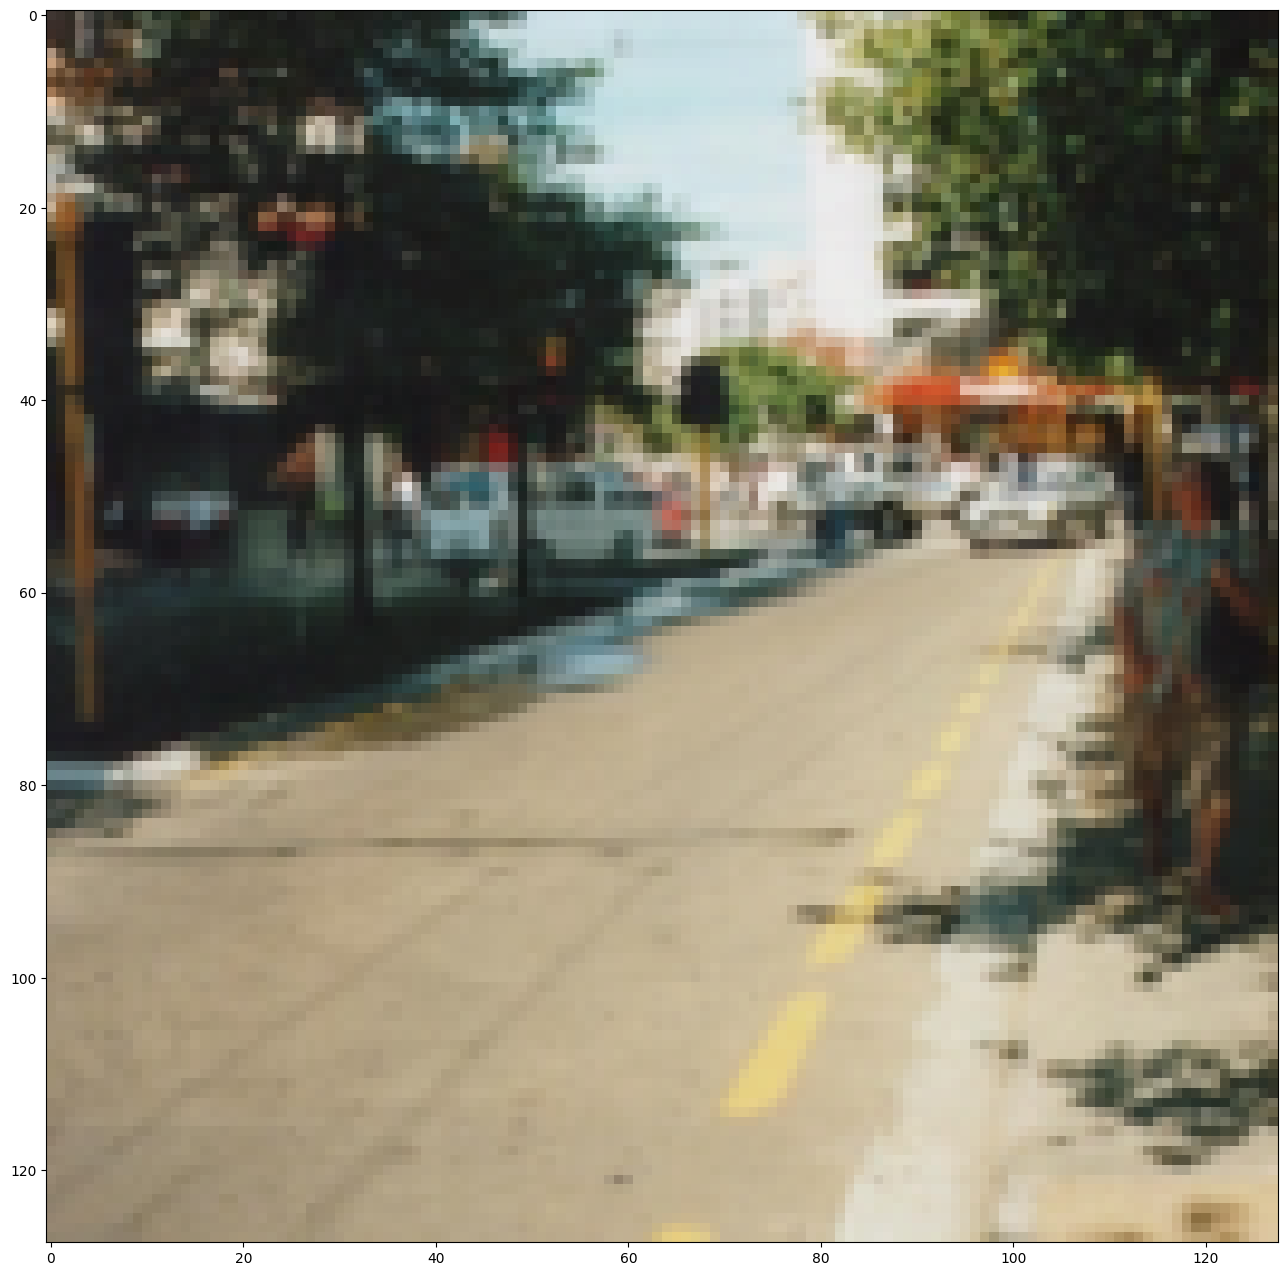

In [166]:
plt.imshow(img_test)

In [158]:
X = convert_tensor(img_test).unsqueeze(0).requires_grad_()

In [160]:
scores = model(X)
score_max_index = scores.argmax()
score_max = scores[0,score_max_index]

In [161]:
score_max

tensor(6.8944, grad_fn=<SelectBackward0>)

In [162]:
score_max.backward()

In [163]:
saliency, _ = torch.max(X.grad.data.abs(),dim=1)

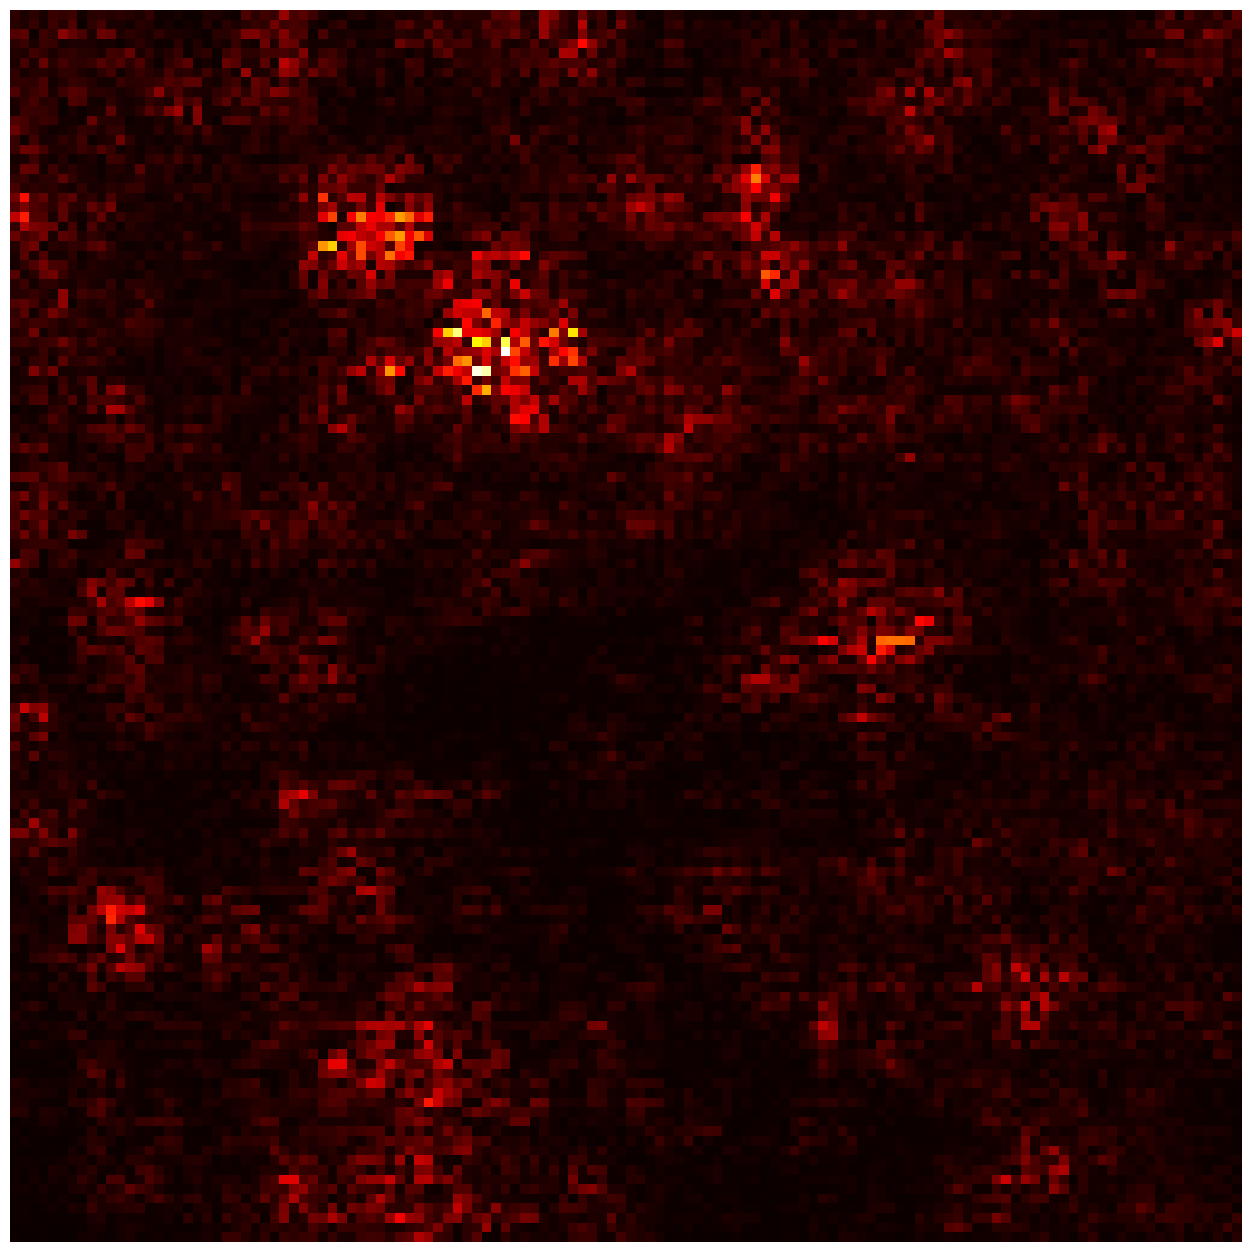

In [164]:
plt.imshow(saliency[0], cmap=plt.cm.hot)
plt.axis('off')
plt.show()

## On gradcam representation

In [170]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [182]:
target_layers = [model.features[-1]]
input_tensor = X

In [183]:
cam  = GradCAM(model=model, target_layers=target_layers)

In [184]:
cam

In [185]:
X.shape

torch.Size([1, 3, 128, 128])

In [188]:
targets = [ClassifierOutputTarget(2)]
print(targets)

grayscale_cam = cam(input_tensor=X, targets=None)


In [191]:
grayscale_cam = grayscale_cam[0, :]
print(grayscale_cam.shape)

(128, 128)


In [194]:
visualization = show_cam_on_image(img_test/255, grayscale_cam, use_rgb=True)


In [195]:
model_outputs = cam.outputs

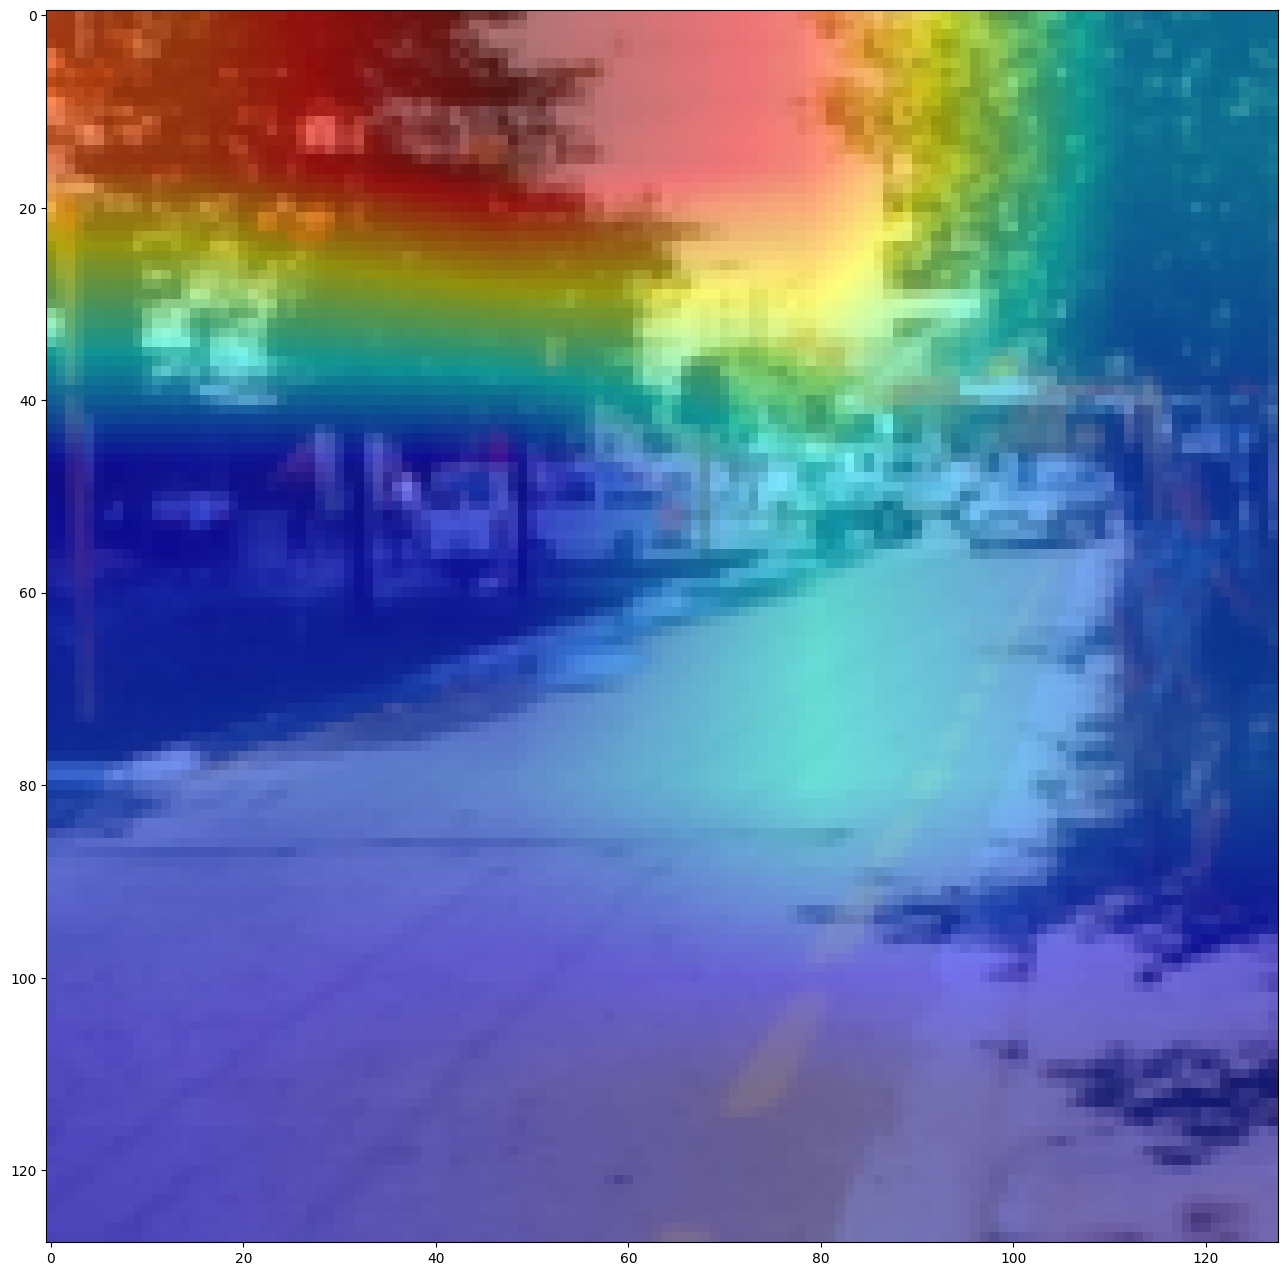

In [198]:
plt.imshow(visualization)

## Explain on higher resolutions

In [402]:
import PIL
image_path = "./data/MIT_split/test/highway/art803.jpg"



t = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [388]:
model = Efficient_net()

k = "scale_"+str((256,256))+"_unfroze3"
model.set_linear(num_classes)
#model.activate_marginal_gradients(3, flow="bottom")

model.load_state_dict(torch.load("./checkpoints/eff/"+key_execution+".pt"))


<All keys matched successfully>

In [390]:
model = model.cuda()

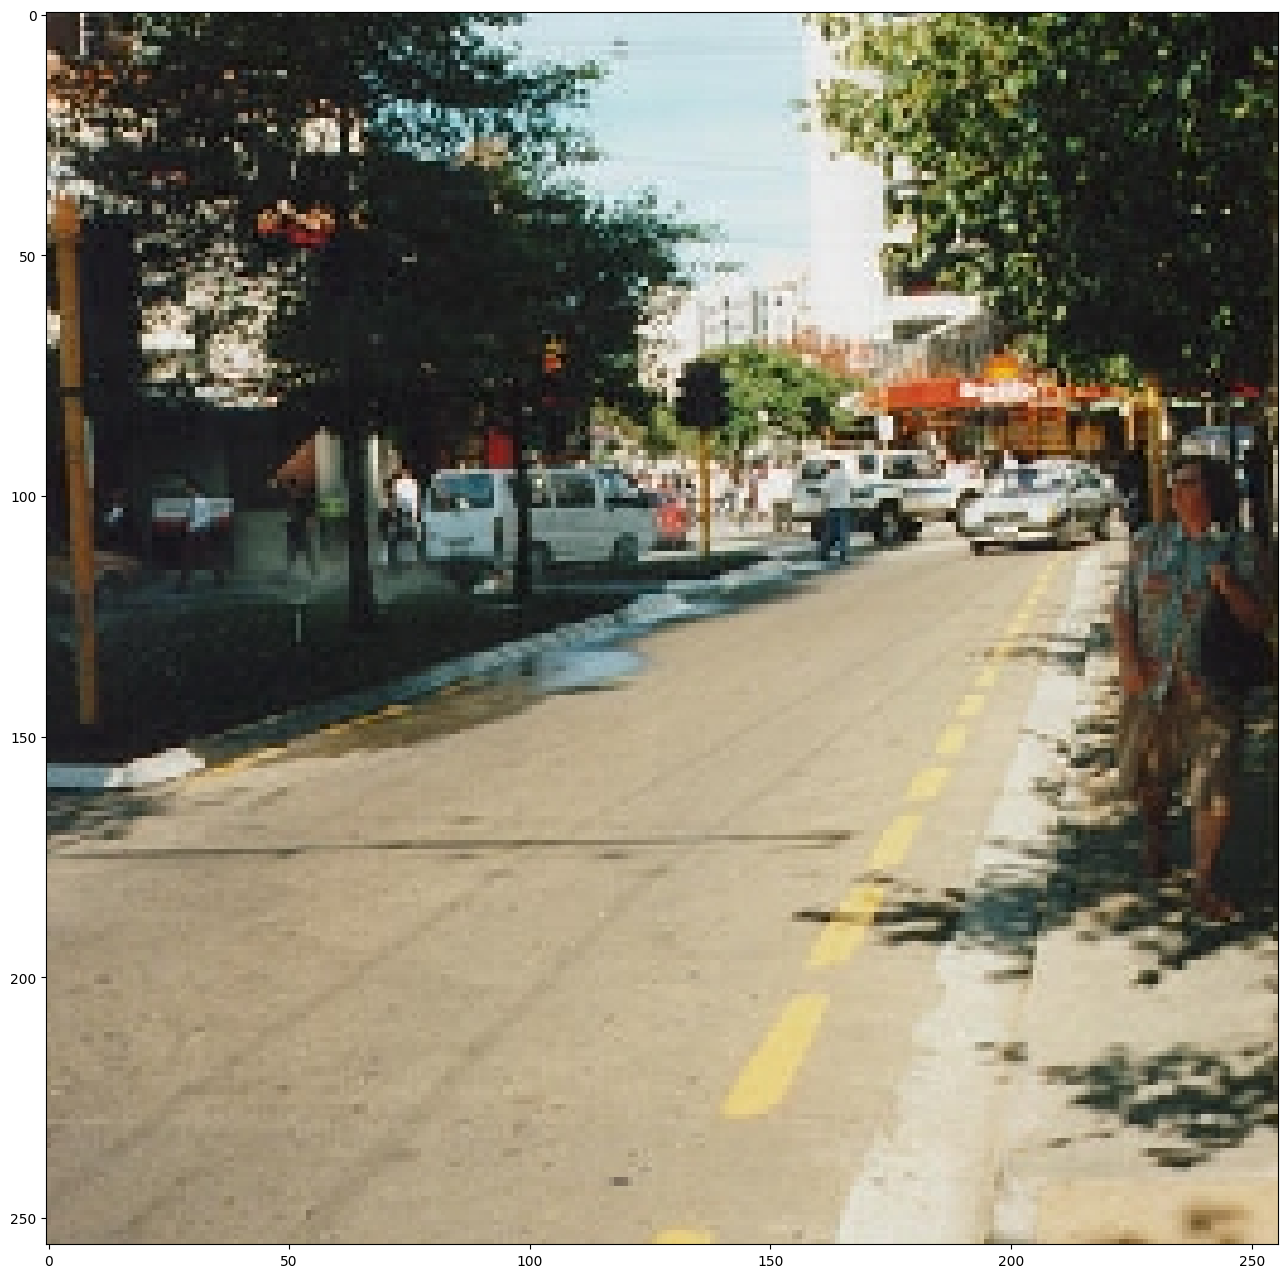

In [403]:
PIL_image = PIL.Image.open(image_path)
input_image= t(PIL_image)

plt.imshow((PIL_image))

In [408]:
model(input_image.unsqueeze(0).cuda())

tensor([[-1.0094, -0.8475, -1.2202, -3.8122, -7.6116, -5.4366,  5.6552, -9.4825]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [409]:
def silence_representation(model, X):
    model.eval()
    X = X.requires_grad_()
    scores = model(X)
    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]
    score_max.backward()
    saliency, _ = torch.max(X.grad.data.abs(),dim=1)

    plt.imshow(saliency[0].cpu(), cmap=plt.cm.hot)
    plt.axis('off')
    plt.show()

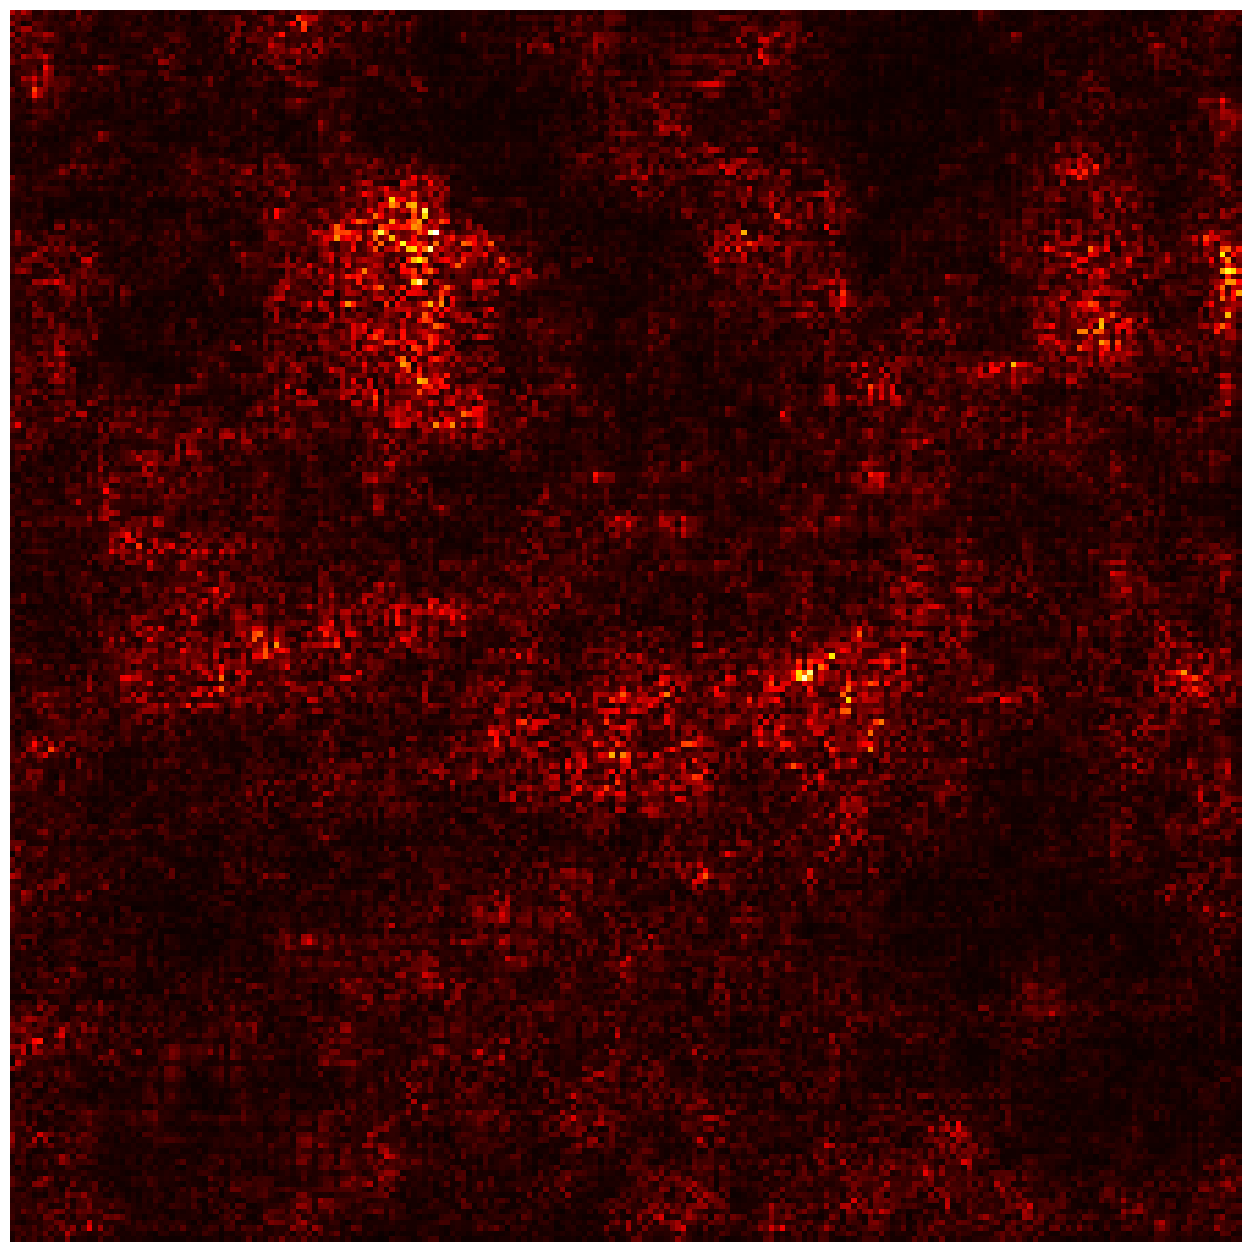

In [410]:
X = input_image.unsqueeze(0).cuda()
silence_representation(model, X)

In [225]:
inverse_mapping_classes

{0: 'Opencountry',
 1: 'coast',
 2: 'forest',
 3: 'highway',
 4: 'inside_city',
 5: 'mountain',
 6: 'street',
 7: 'tallbuilding'}

In [398]:
validate(model=model.cuda(), criterion=criterion, loader=dataloaders_dict["test"])

test Loss: 0.1484 Acc: 0.9628


## Reeapplying gradCam

In [411]:
target_layers = [model.features[-1]]
input_tensor = X

In [412]:
cam  = GradCAM(model=model, target_layers=target_layers)
grayscale_cam = cam(input_tensor=X, targets=None)


In [413]:
grayscale_cam = grayscale_cam[0, :]
print(grayscale_cam.shape)

(224, 224)


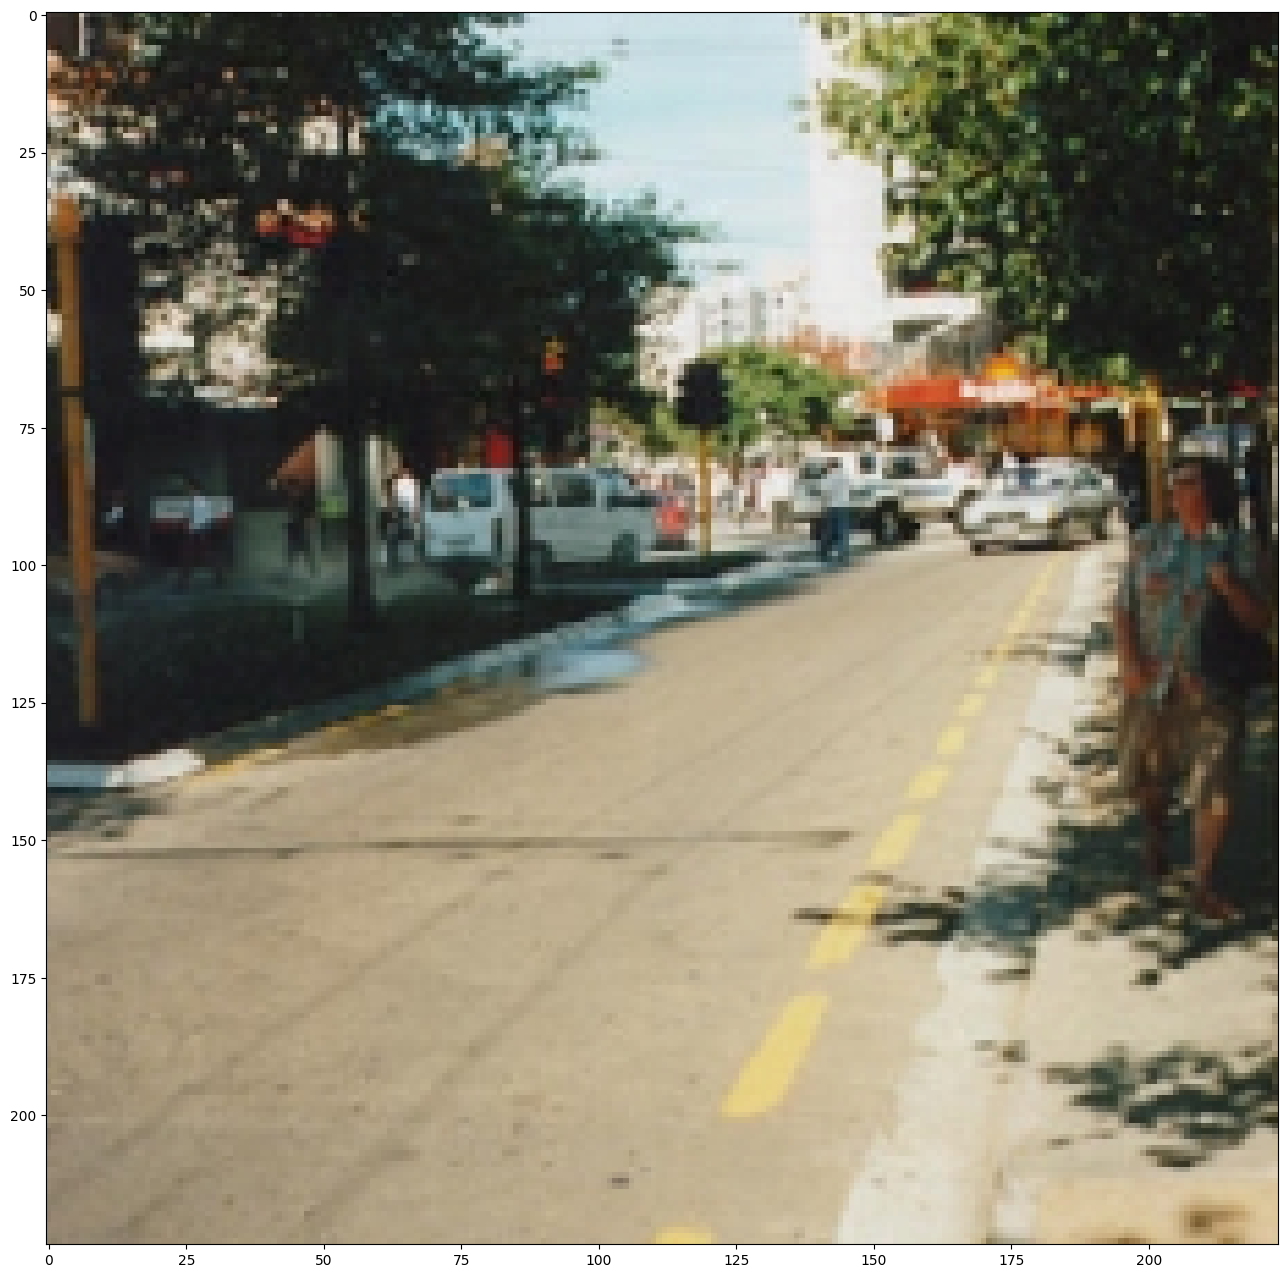

In [421]:
plt.imshow(tensor_to_image(input_image))

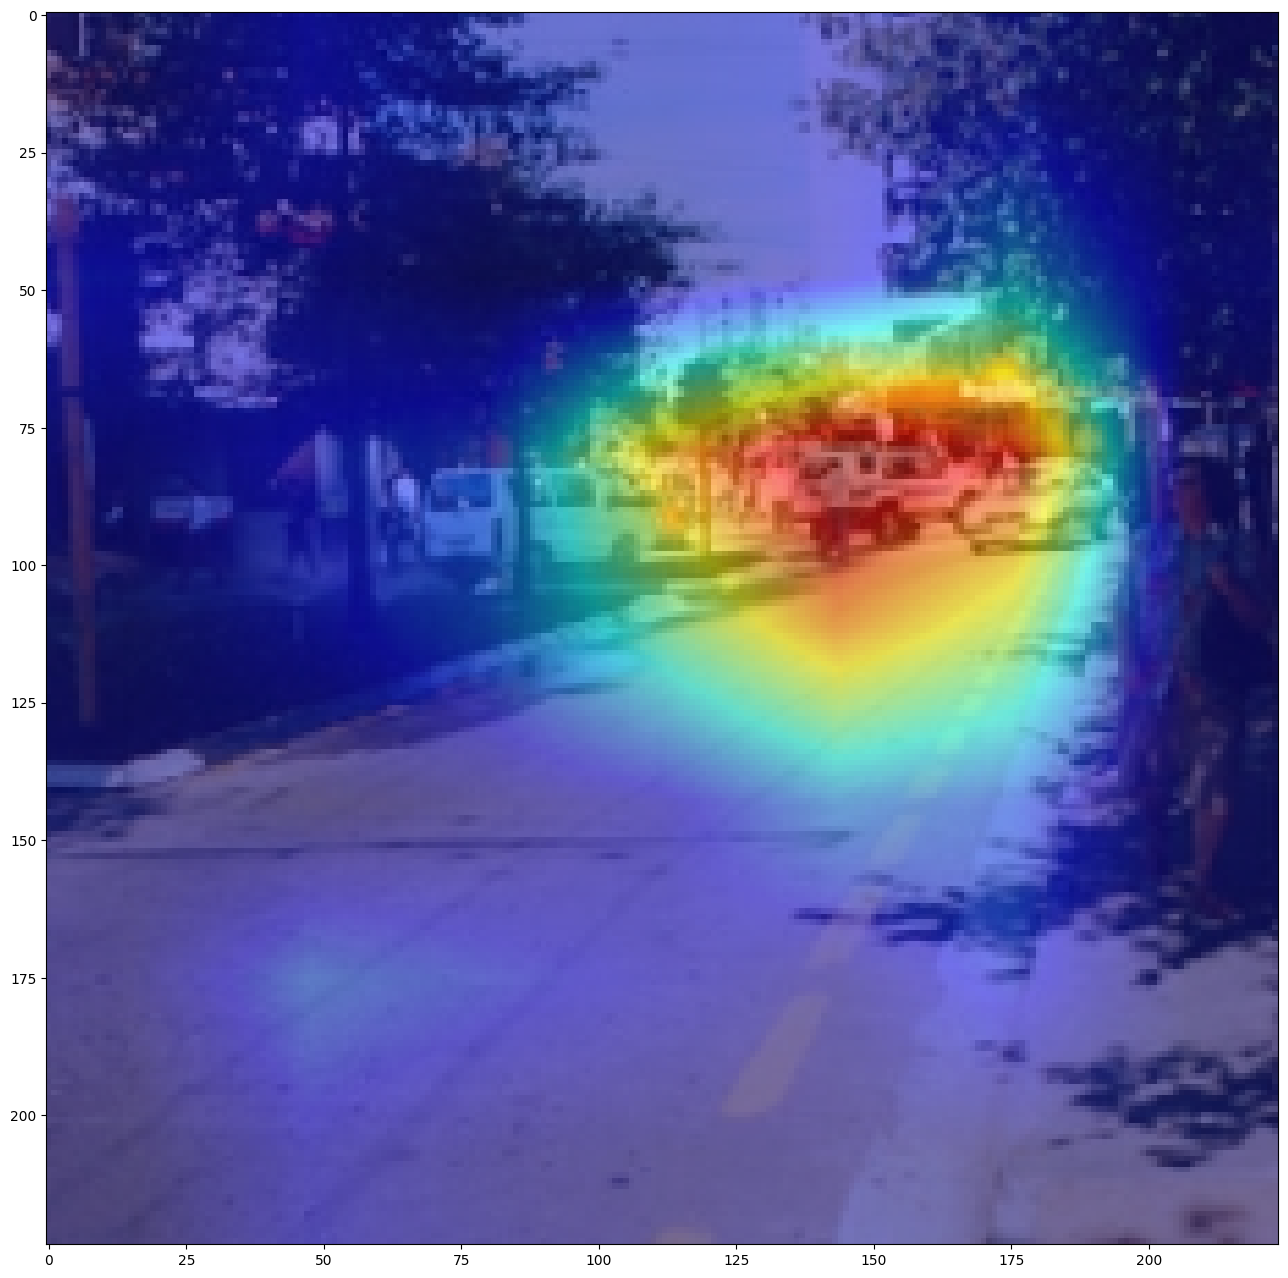

In [422]:
visualization = show_cam_on_image(tensor_to_image(input_image)/255, grayscale_cam, use_rgb=True)
plt.imshow(visualization)
